# Deconvolving the Mixing Matrix

The goal of this notebook is showcase the natural unmixing method to account for masking in the fields implemented in Heracles.


## Dependencies

In [1]:
import heracles
import numpy as np
import healpy as hp
import matplotlib as mpl
import matplotlib.pyplot as plt
from heracles.twopoint import mixing_matrices
from heracles.result import Result

## Data Maps

In [2]:
from heracles.healpy import HealpixMapper
from heracles.fields import Positions, Shears, Visibility, Weights

nside = 512
lmax = 600
nbins = 7

In [4]:
data_maps = heracles.read_maps("./example-data_maps.fits")
mapper = HealpixMapper(nside=nside, lmax=lmax)
fields = {
    "POS": Positions(mapper, mask="VIS"),
    "SHE": Shears(mapper, mask="WHT"),
    "VIS": Visibility(mapper),
    "WHT": Weights(mapper),
}
mask_mapper = HealpixMapper(nside=2 * nside, lmax=2 * lmax)
mask_fields = {
    "POS": Positions(mapper, mask="VIS"),
    "SHE": Shears(mapper, mask="WHT"),
    "VIS": Visibility(mapper),
    "WHT": Weights(mapper),
}

In [6]:
data_maps = heracles.read_maps("./example-data_maps.fits")
for key in list(data_maps.keys()):
    f, i = key
    if i <= nbins:
        _map = data_maps[key]
        meta = _map.dtype.metadata
        new_map = hp.ud_grade(_map, nside)
        heracles.update_metadata(
            new_map,
            nside=nside,
            lmax=lmax,
            bias=meta["bias"],
            fsky=meta["fsky"],
            spin=meta["spin"],
        )
        data_maps[key] = new_map
    else:
        data_maps.pop(key)

# load the FITS mask
vis_map = hp.read_map("./vmap.fits.gz")
vis_map[vis_map == hp.UNSEEN] = 0.0
vis_map = hp.ud_grade(vis_map, nside)
heracles.update_metadata(
    vis_map,
    nside=nside,
    lmax=lmax,
    bias=0.0,
    fsky=meta["fsky"],
    spin=0,
)
vis_maps = {}
for key in list(data_maps.keys()):
    f, i = key
    if f == "POS":
        f = "VIS"
    if f == "SHE":
        f = "WHT"
    key = (f, i)
    vis_maps[key] = vis_map

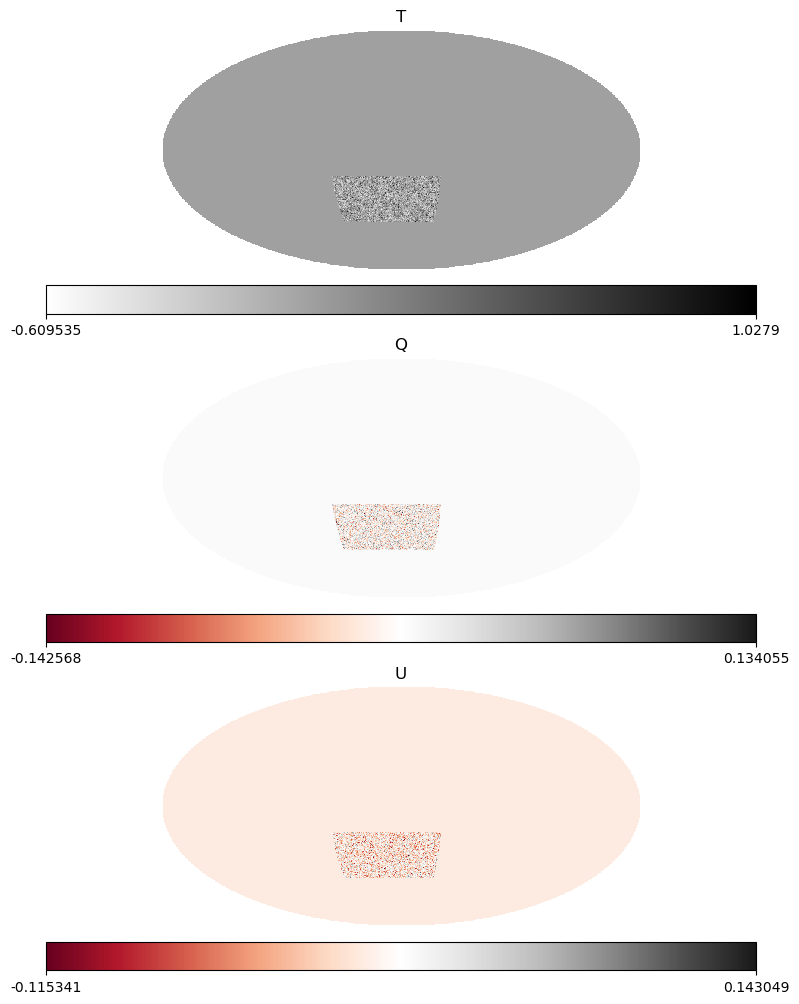

In [7]:
fig, ax = plt.subplots(3, figsize=(20, 10))
fig.tight_layout()
plt.sca(ax[0])
hp.mollview(data_maps[("POS", 1)], cmap="binary", title="T", hold=True)
# hp.visufunc.projplot(thetas[:200], phis[:200], 'ro')
plt.sca(ax[1])
hp.mollview(data_maps[("SHE", 1)][0], cmap="RdGy", title="Q", hold=True)
plt.sca(ax[2])
hp.mollview(data_maps[("SHE", 1)][1], cmap="RdGy", title="U", hold=True)
plt.show()

In [8]:
alms = heracles.transform(fields, data_maps)
cls = heracles.angular_power_spectra(alms)
for key in cls.keys():
    r = cls[key].array
    *_, nl = np.atleast_2d(r).shape
    ell = np.arange(nl)
    cls[key] = Result(r, axis=cls[key].axis, ell=ell)

In [9]:
mask_alms = heracles.transform(mask_fields, vis_maps)
mask_cls = heracles.angular_power_spectra(mask_alms)

In [10]:
from heracles.notebook import Progress

with Progress("mixmats") as progress:
    mms = mixing_matrices(
        fields,
        mask_cls,
        l1max=lmax,
        l2max=2 * lmax,
        l3max=2 * lmax + lmax,
        progress=progress,
    )

VBox()

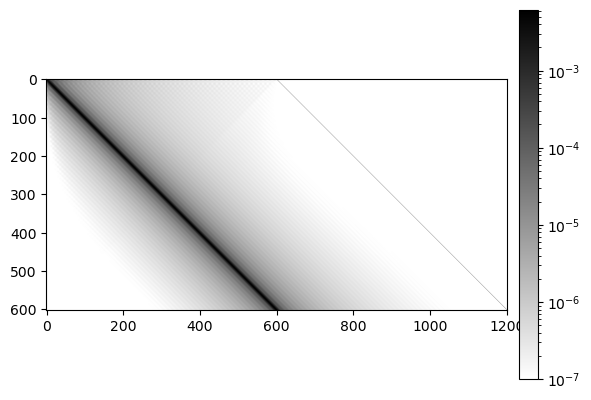

In [11]:
plt.imshow(
    mms["SHE", "SHE", 2, 2][0], cmap="binary", norm=mpl.colors.LogNorm(vmin=1e-7)
)
plt.colorbar(pad=0.025, fraction=0.0465)
plt.show()

## Theory

In [12]:
import camb
from camb.sources import SplinedSourceWindow

In [13]:
# cosmology for the simulation
h = 0.7
Oc = 0.25
Ob = 0.05

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(
    H0=100 * h, omch2=Oc * h**2, ombh2=Ob * h**2, NonLinear=camb.model.NonLinear_both
)
pars.Want_CMB = False
pars.min_l = 1
pars.set_for_lmax(2 * lmax, lens_potential_accuracy=1);

In [14]:
with np.load("nz.npz") as npz:
    z, nz = npz["z"], npz["nz"]

In [15]:
sources = []
for i, nz_i in enumerate(nz):
    sources += [
        SplinedSourceWindow(source_type="counts", z=z, W=nz_i),
        SplinedSourceWindow(source_type="lensing", z=z, W=nz_i),
    ]
pars.SourceWindows = sources

In [16]:
results = camb.get_results(pars)
camb_cls = results.get_source_cls_dict(lmax=2 * lmax, raw_cl=True)

In [17]:
ell = np.arange(lmax + 1)
ell2 = np.arange(2 * lmax + 1)
fl = -np.sqrt((ell2 + 2) * (ell2 + 1) * ell2 * (ell2 - 1))
fl /= np.clip(ell2 * (ell2 + 1), 1, None)

In [18]:
theory = {}
for i in range(1, nbins):
    for j in range(i, nbins):
        # all mixing matrix combinations
        theory["POS", "POS", i, j] = camb_cls[f"W{2 * i - 1}xW{2 * j - 1}"]
        theory["POS", "SHE", i, j] = np.stack(
            [
                fl * camb_cls[f"W{2 * i - 1}xW{2 * j}"],
                np.zeros_like(ell2),
            ]
        )
        theory["POS", "SHE", j, i] = np.stack(
            [
                fl * camb_cls[f"W{2 * i}xW{2 * j - 1}"],
                np.zeros_like(ell2),
            ]
        )
        theory["SHE", "SHE", i, j] = np.stack(
            [
                [fl**2 * camb_cls[f"W{2 * i}xW{2 * j}"], np.zeros_like(ell2)],
                [np.zeros_like(ell2), np.zeros_like(ell2)],
            ]
        )

for key in theory.keys():
    c = cls[key]
    print(key, c.array.shape, c.axis, theory[key].shape, theory[key].dtype)
    theory[key] = Result(theory[key], axis=c.axis, ell=ell2)

('POS', 'POS', 1, 1) (601,) (0,) (1201,) float64
('POS', 'SHE', 1, 1) (2, 601) (1,) (2, 1201) float64
('SHE', 'SHE', 1, 1) (2, 2, 601) (2,) (2, 2, 1201) float64
('POS', 'POS', 1, 2) (601,) (0,) (1201,) float64
('POS', 'SHE', 1, 2) (2, 601) (1,) (2, 1201) float64
('POS', 'SHE', 2, 1) (2, 601) (1,) (2, 1201) float64
('SHE', 'SHE', 1, 2) (2, 2, 601) (2,) (2, 2, 1201) float64
('POS', 'POS', 1, 3) (601,) (0,) (1201,) float64
('POS', 'SHE', 1, 3) (2, 601) (1,) (2, 1201) float64
('POS', 'SHE', 3, 1) (2, 601) (1,) (2, 1201) float64
('SHE', 'SHE', 1, 3) (2, 2, 601) (2,) (2, 2, 1201) float64
('POS', 'POS', 1, 4) (601,) (0,) (1201,) float64
('POS', 'SHE', 1, 4) (2, 601) (1,) (2, 1201) float64
('POS', 'SHE', 4, 1) (2, 601) (1,) (2, 1201) float64
('SHE', 'SHE', 1, 4) (2, 2, 601) (2,) (2, 2, 1201) float64
('POS', 'POS', 1, 5) (601,) (0,) (1201,) float64
('POS', 'SHE', 1, 5) (2, 601) (1,) (2, 1201) float64
('POS', 'SHE', 5, 1) (2, 601) (1,) (2, 1201) float64
('SHE', 'SHE', 1, 5) (2, 2, 601) (2,) (2, 

## Binning

In [19]:
nlbins = 10
ledges = np.logspace(np.log10(10), np.log10(lmax), nlbins + 1)

## Plotting

In [20]:
def plot_clustering(cls, theory):
    bins = [key[3] for key in cls.keys()]
    nbins = max(bins) + 1
    fig, ax = plt.subplots(
        nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True
    )

    for i in range(1, nbins):
        for j in range(1, i):
            ax[j - 1, i - 1].axis("off")
        for j in range(i, nbins):
            ax[j - 1, i - 1].plot(
                cls["POS", "POS", i, j].ell[1:],
                cls["POS", "POS", i, j][1:],
                c="C0",
                lw=1.5,
                zorder=3.0,
                alpha=0.5,
            )
            ax[j - 1, i - 1].plot(
                theory["POS", "POS", i, j].ell[1:],
                theory["POS", "POS", i, j][1:],
                c="C0",
                lw=1.0,
                zorder=4.0,
            )
            ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
            ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

    ax[0, 0].set_xscale("log")
    ax[0, 0].set_xlim(1 / 3, lmax * 3)
    ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
    ax[0, 0].xaxis.get_minor_locator().set_params(
        numticks=99, subs=np.arange(0.1, 1.0, 0.1)
    )
    ax[0, 0].set_yscale(
        "symlog", linthresh=1e-7, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
    )
    ax[0, 0].set_ylim(-2e-7, 2e-4)

    fig.subplots_adjust(
        left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0
    )

    fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
    fig.supylabel("galaxy clustering $C_\\ell$", x=-0.1, ha="right")

    plt.show()
    return fig


def plot_shear(cls, theory):
    bins = [key[3] for key in cls.keys()]
    nbins = max(bins) + 1
    fig, ax = plt.subplots(
        nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True
    )

    for i in range(1, nbins):
        for j in range(1, i):
            ax[j - 1, i - 1].axis("off")
        for j in range(i, nbins):
            ax[j - 1, i - 1].plot(
                cls["SHE", "SHE", i, j].ell[2:],
                cls["SHE", "SHE", i, j][0, 0, 2:],
                c="C0",
                lw=1.5,
                zorder=3.0,
                alpha=0.5,
            )
            ax[j - 1, i - 1].plot(
                theory["SHE", "SHE", i, j].ell[2:],
                theory["SHE", "SHE", i, j][0, 0, 2:],
                c="C0",
                lw=1.0,
                zorder=4.0,
            )
            ax[j - 1, i - 1].plot(
                cls["SHE", "SHE", i, j].ell[2:],
                cls["SHE", "SHE", i, j][1, 1, 2:],
                c="C1",
                lw=1.5,
                zorder=1.0,
                alpha=0.5,
            )
            ax[j - 1, i - 1].plot(
                theory["SHE", "SHE", i, j].ell[2:],
                theory["SHE", "SHE", i, j][1, 1, 2:],
                c="C1",
                lw=1.0,
                zorder=2.0,
            )
            ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
            ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

    ax[0, 0].set_xscale("log")
    ax[0, 0].set_xlim(1 / 3, lmax * 3)
    ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
    ax[0, 0].xaxis.get_minor_locator().set_params(
        numticks=99, subs=np.arange(0.1, 1.0, 0.1)
    )
    ax[0, 0].set_yscale(
        "symlog", linthresh=1e-10, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
    )
    ax[0, 0].set_ylim(-3e-10, 5e-7)

    fig.subplots_adjust(
        left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0
    )

    fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
    fig.supylabel("cosmic shear $C_\\ell$", x=-0.1, ha="right")

    plt.show()
    return fig


def plot_clusteringxshear(cls, theory):
    bins = [key[3] for key in cls.keys()]
    nbins = max(bins) + 1
    fig, ax = plt.subplots(
        nbins - 1, nbins - 1, figsize=(6, 6), sharex=True, sharey=True
    )

    for i in range(1, nbins):
        for j in range(1, nbins):
            ax[j - 1, i - 1].plot(
                cls["POS", "SHE", i, j].ell[2:],
                cls["POS", "SHE", i, j][0, 2:],
                c="C0",
                lw=1.5,
                zorder=3.0,
                alpha=0.5,
            )
            ax[j - 1, i - 1].plot(
                theory["POS", "SHE", i, j].ell[2:],
                theory["POS", "SHE", i, j][0, 2:],
                c="C0",
                lw=1.0,
                zorder=4.0,
            )
            ax[j - 1, i - 1].plot(
                cls["POS", "SHE", i, j].ell[2:],
                cls["POS", "SHE", i, j][1, 2:],
                c="C1",
                lw=1.5,
                zorder=1.0,
                alpha=0.5,
            )
            ax[j - 1, i - 1].plot(
                theory["POS", "SHE", i, j].ell[2:],
                theory["POS", "SHE", i, j][1, 2:],
                c="C1",
                lw=1.0,
                zorder=2.0,
            )
            ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
            ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

    ax[0, 0].set_xscale("log")
    ax[0, 0].set_xlim(1 / 3, lmax * 3)
    ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
    ax[0, 0].xaxis.get_minor_locator().set_params(
        numticks=99, subs=np.arange(0.1, 1.0, 0.1)
    )
    ax[0, 0].set_yscale(
        "symlog", linthresh=1e-9, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1)
    )
    ax[0, 0].set_ylim(-8e-6, 4e-8)

    fig.subplots_adjust(
        left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0
    )

    fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
    fig.supylabel("galaxy--galaxy lensing $C_\\ell$", x=-0.1, ha="right")

    plt.show()

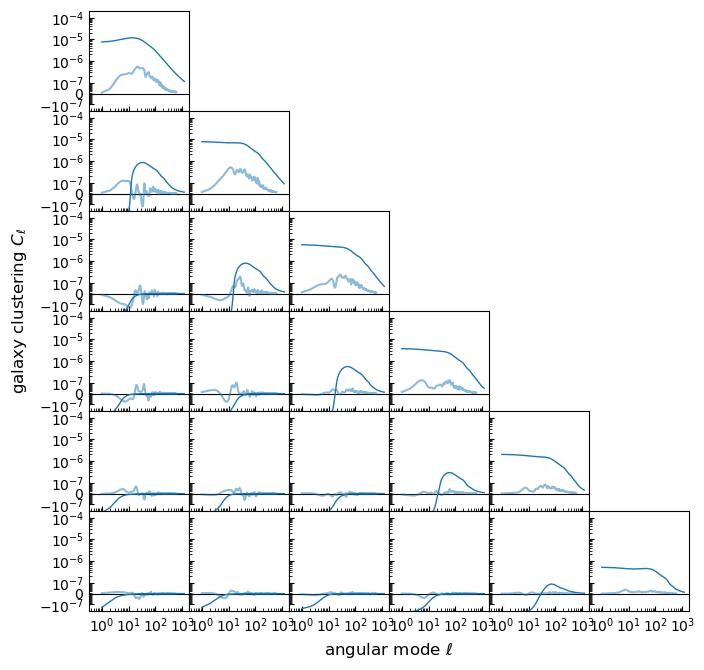

In [21]:
plot_clustering(cls, theory);

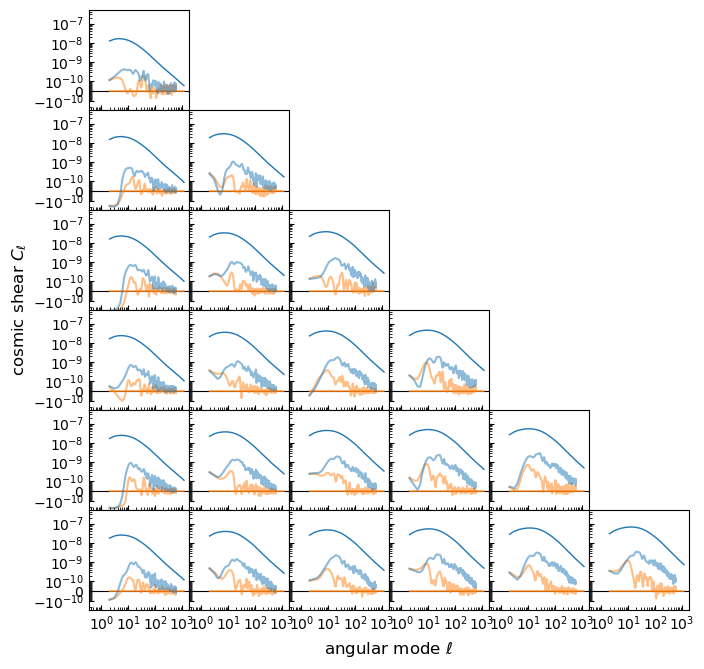

In [22]:
plot_shear(cls, theory);

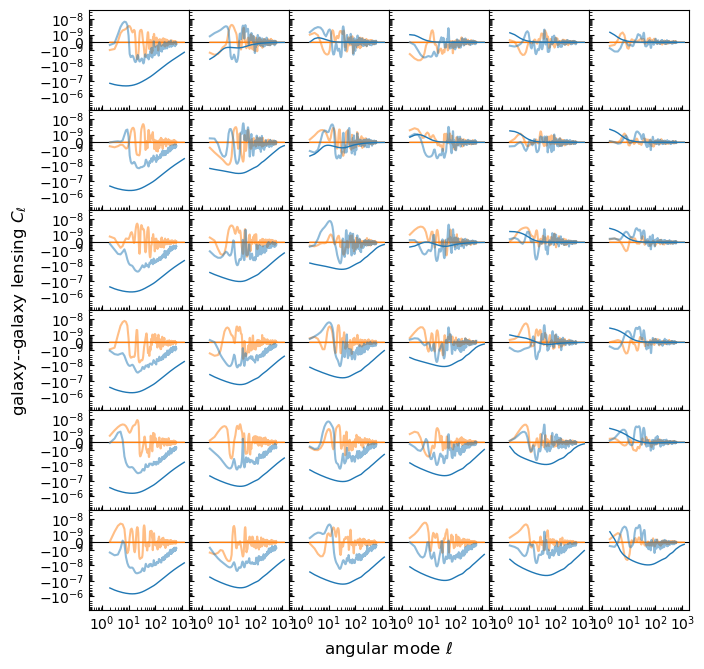

In [23]:
plot_clusteringxshear(cls, theory);

## Natural Unmixing

In the nautral unmixing method we account for the effect of the mask in real space. 
Let's start laying down some definitions. Given a complex field:
$$ \gamma(n) = (Q \pm i U)(n) = \sum_{l m} (E_{l m} \mp i B_{l m}) _{\mp 2} Y_{l m}(n)  $$
we can define the correlators:
$$ \xi_{+} = \langle \gamma^* \gamma\rangle  \hspace{6pt}\rm{and}\hspace{6pt} \xi_{-} = \langle \gamma \gamma \rangle $$
Then the associated parital sky correlatiors are given by:
$$ \xi_{\pm}(\theta) = \frac{\tilde{\xi}_{\pm}(\theta)}{\xi^{ww'}(\theta)} $$
which we can also express in terms of linear combinations of the measured $E$ and $B$ angular power spectra:
$$  \tilde{\xi}_{\pm}(\theta) = \sum_l \frac{2l+1}{4\pi}(\tilde{C}^{EE}_l \pm  \tilde{C}^{BB}_l) d^l_{2 \pm 2}(\theta) $$

The PolSpice method undoes the $E-B$ coupling by defining a correlator akin to $\xi_{+}(\theta)$ but with the Wigner matrix of a spin -2 field:
$$
\xi_{\rm dec}(\theta) = \frac{\tilde{\xi}_{\rm dec}(\theta)}{\xi^{ww'}(\theta)} = \nonumber \\ 
= \frac{1}{\xi^{ww'}(\theta)} \sum_l \frac{2l+1}{4\pi}(\tilde{C}^{EE}_l +  \tilde{C}^{BB}_l) d^l_{2 - 2}(\theta)
$$

Then one can construct a estimator for the full sky angular correlation functions by combining the correlation function and inverting the SWSH transform:
$$
C^{EE}_l = 2\pi \int \frac{1}{2}[\xi_{\rm dec}(\theta) + \xi_{-}(\theta)] d^{l}_{2-2}(\theta) {\rm d}\!\cos{\theta} $$
$$
C^{BB}_l = 2\pi \int \frac{1}{2}[\xi_{\rm dec}(\theta) - \xi_{-}(\theta)] d^{l}_{2-2}(\theta) {\rm d}\!\cos{\theta} $$

In [24]:
nu_d = heracles.natural_unmixing(cls, mask_cls, patch_hole=True)
nu_dq = heracles.binned(nu_d, ledges)
theory_q = heracles.binned(theory, ledges)

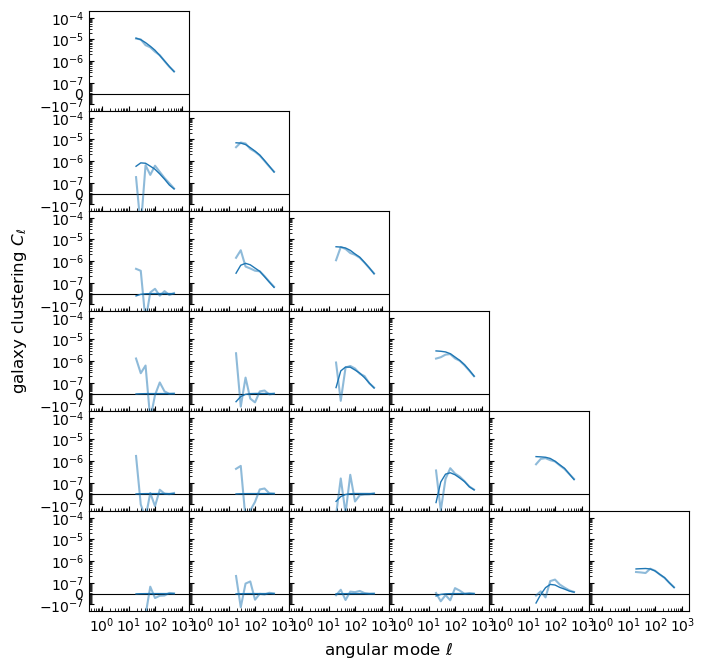

In [25]:
plot_clustering(nu_dq, theory_q);

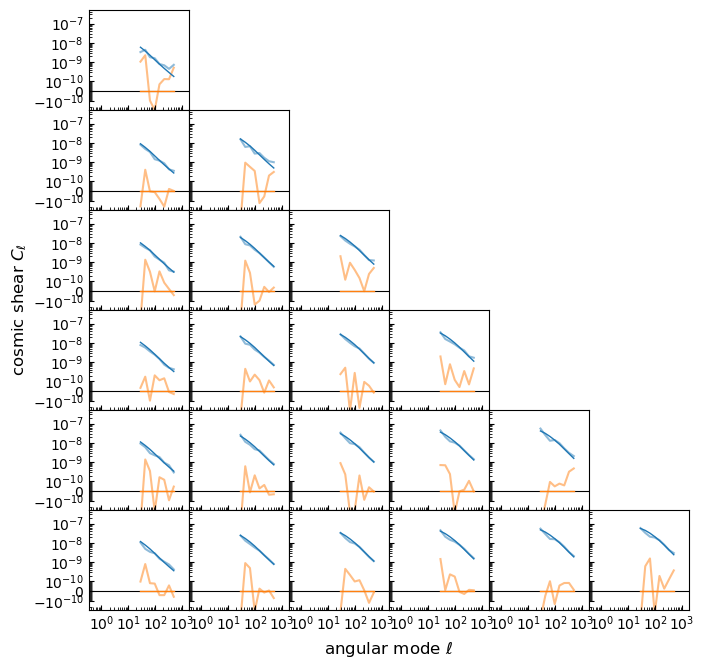

In [26]:
plot_shear(nu_dq, theory_q);

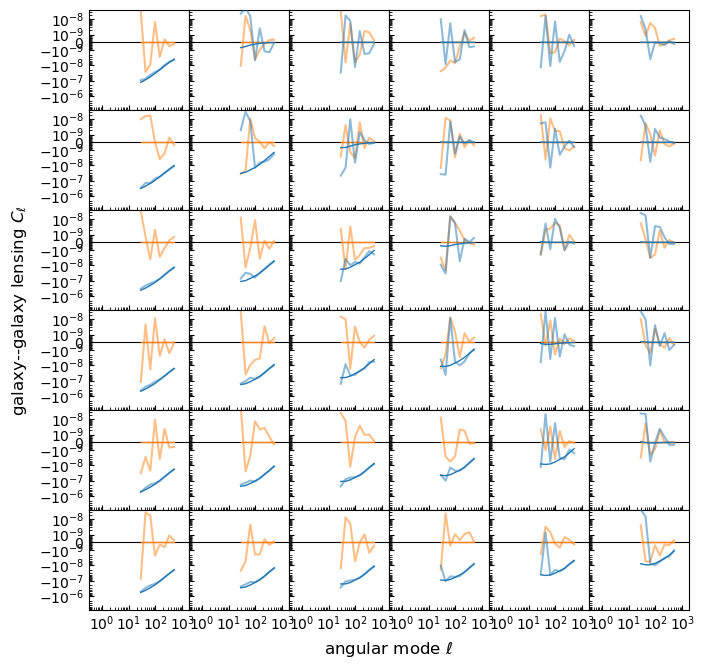

In [27]:
plot_clusteringxshear(nu_dq, theory_q);